# Q5. Data Augmentation

In [1]:
import tensorflow as tf
import keras
(X_train, y_train), (X_test,y_test) = keras.datasets.cifar10.load_data()
X_train = X_train/255.0
X_test = X_test/255.0

170498071/170498071 [==============================] - 3s 0us/step


In [2]:
import matplotlib.pyplot as plt

tf.random.set_seed(40)

def visualize_augmentation(augment_function, title, X_train, y_train):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(title, fontsize=16)
    img_index = 50  # Using a fixed image index for consistent visualization

    for i, ax in enumerate(axes):
        original_img = X_train[img_index]
        augmented_img, _ = augment_function(original_img, y_train[img_index])

        image_to_display = tf.clip_by_value(augmented_img if i != 0 else original_img, 0, 1)

        ax.imshow(image_to_display)
        ax.set_title("Original" if i == 0 else "Augmented " + str(i))
        ax.axis('off')
    plt.show()

## Task 1. Geometric Augmentations (40 Points)
**Objective**: Write a codes for geometric augmentations as below instructions

### **Instructions**

- Step 1: Flip the image horizontally
  - Use tf.image.random_flip_left_right to flip the image left and right randomly.


- Step 2: Generate a random bounding box for cropping
  - Use tf.image.sample_distorted_bounding_box to generate a random bounding box.
  - Make sure at least 20% of the image is covered, the crop is square, and the area is between 50% and 100% of the image area.


- Step 3: Crop and resize the image
  - Convert the bounding box from [1, 1, 4] to [1, 4] using tf.squeeze.
  - Then use tf.image.crop_and_resize to crop and resize the image to 32x32 pixels.
  - Make sure to add a batch dimension before cropping and remove it afterward.

- References
  - tf.image.random_flip_left_right: https://www.tensorflow.org/api_docs/python/tf/image/random_flip_left_right
  - tf.image.sample_distorted_bounding_box: https://www.tensorflow.org/api_docs/python/tf/image/sample_distorted_bounding_box
  - tf.squeeze: https://www.tensorflow.org/api_docs/python/tf/squeeze
  - tf.image.crop_and_resize: https://www.tensorflow.org/api_docs/python/tf/image/crop_and_resize


- *You should print the same figures as shown in the example below.*


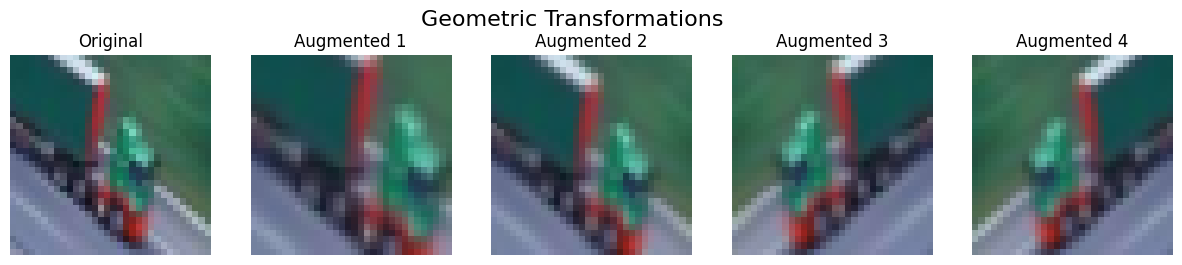

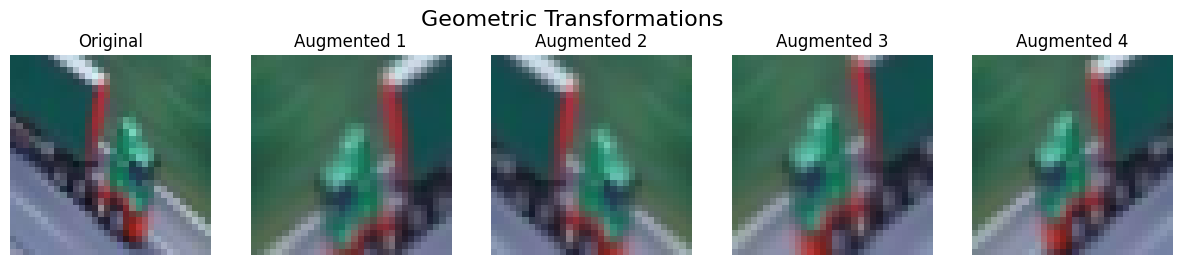

In [7]:
# Geometric trnsformation
def augment_geometric(image, label):
    # Step 1: Flip the image horizontally
    image = tf.image.random_flip_left_right(image)

    # Step 2: Generate a random bounding box for cropping
    bbox_begin, bbox_size, bbox = tf.image.sample_distorted_bounding_box(
        tf.shape(image),
        bounding_boxes=tf.constant([[[0.0, 0.0, 1.0, 1.0]]], dtype=tf.float32),
        min_object_covered=0.2,
        aspect_ratio_range=(1.0, 1.0),
        area_range=(0.5, 1.0),
        use_image_if_no_bounding_boxes=True
    )

    # Step 3: Crop and resize the image
    bbox = tf.squeeze(bbox)
    cropped_image = tf.image.crop_and_resize(
        tf.expand_dims(image, axis=0),
        boxes=[bbox],
        box_indices=[0],
        crop_size=[32, 32]
    )
    cropped_image = tf.squeeze(cropped_image, axis=0)

    return cropped_image, label

visualize_augmentation(augment_geometric, "Geometric Transformations", X_train.copy(), y_train.copy())

## Task 2. Noise Augmentation (30 Points)

**Objective**: Write a code for noise augmentation as below instructions.


### **Instructions**

- Step 1: Generate random Gaussian noise
  - Randomly choose a standard deviation for the noise between 0.0 and 0.1.
  - Use tf.random.uniform for the standard deviation and tf.random.normal to generate the noise.

- Step 2: Add the noise to the image
  - Add the noise to the image
  - Use tf.clip_by_value to clip the image values and ensure they are within the range [0, 1].

- References
  - tf.random.uniform: https://www.tensorflow.org/api_docs/python/tf/random/uniform
  - tf.random.normal: https://www.tensorflow.org/api_docs/python/tf/random/normal
  - tf.clip_by_value: https://www.tensorflow.org/api_docs/python/tf/clip_by_value

- *You should print the same figures as shown in the example below.*


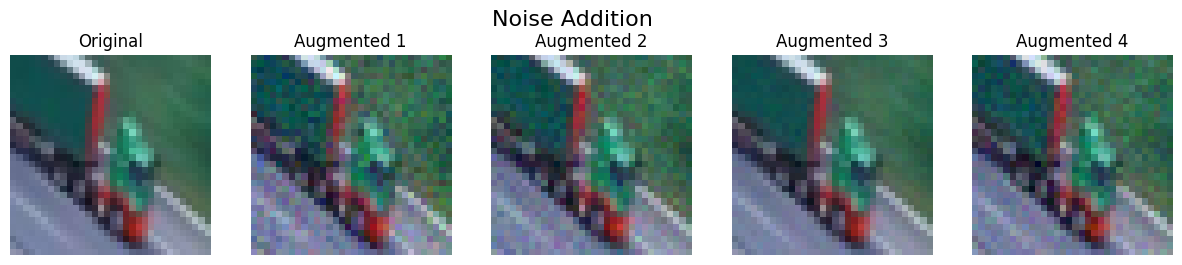

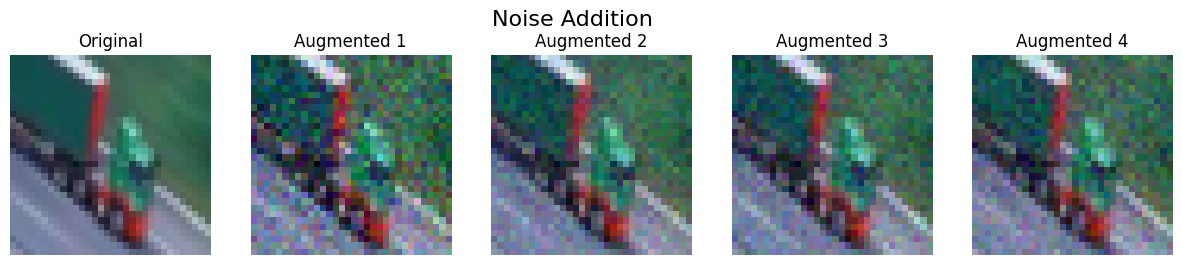

In [10]:
# Noise addition
def augment_noise(image, label):
    # Step 1: Generate random Gaussian noise
    stddev = tf.random.uniform([], 0.0, 0.1)
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=stddev)

    # Step 2: Add the noise to the image
    image = image + noise
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

visualize_augmentation(augment_noise, "Noise Addition", X_train.copy(), y_train.copy())

## Task 3. Masking Augmentation (30 Points)

**Objective**: Write a code for masking augmentation by following below instructions.

### **Instructions**

- Step 1: Generate dimensions and position for the mask
  - Randomly choose the width and height of the mask between 5 and 15 pixels.
  - Also, randomly choose the position of the mask such that it fits within the image dimensions.

- Step 2: Create and apply the mask
  - Create a black mask of the chosen size and place it at the chosen position within the image.
  - Use tf.zeros to create the mask and tf.pad to position it.
  - Multiply the mask with the image to apply it.

- References
  - tf.zeros: https://www.tensorflow.org/api_docs/python/tf/zeros
  - tf.pad: https://www.tensorflow.org/api_docs/python/tf/pad

- *You should print the same figures as shown in the example below.*

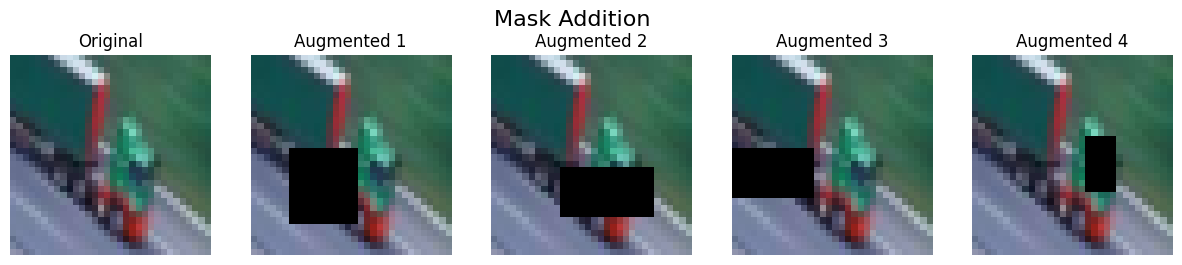

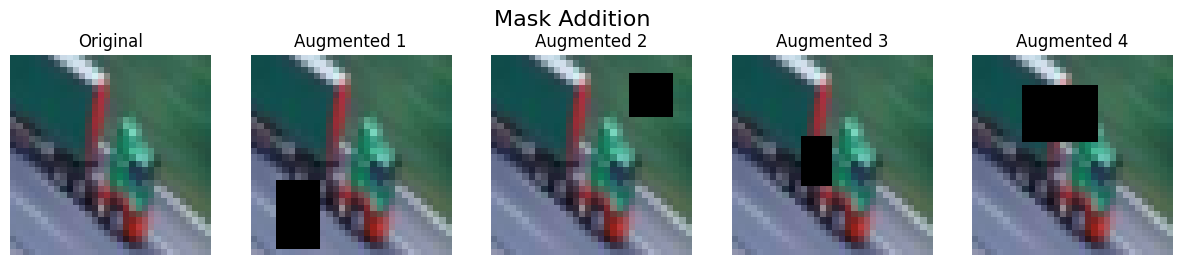

In [11]:
def augment_masking(image, label):
    # Step 1: Generate dimensions and position for the mask
    mask_height = tf.random.uniform([], 5, 15, dtype=tf.int32)
    mask_width = tf.random.uniform([], 5, 15, dtype=tf.int32)
    image_height, image_width, _ = image.shape

    max_y = image_height - mask_height
    max_x = image_width - mask_width

    top = tf.random.uniform([], 0, max_y, dtype=tf.int32)
    left = tf.random.uniform([], 0, max_x, dtype=tf.int32)

    # Step 2: Create and apply the mask
    mask = tf.zeros((mask_height, mask_width, 3), dtype=image.dtype)
    padding = [[top, image_height - mask_height - top],
               [left, image_width - mask_width - left],
               [0, 0]]
    mask = tf.pad(mask, padding, mode='CONSTANT', constant_values=1)  # Invert mask values for multiplication

    image = image * mask  # Apply mask

    return image, label

visualize_augmentation(augment_masking, "Mask Addition", X_train.copy(), y_train.copy())